Program Name: Jet_Length_Width_Determiner_v1.py

Date: 6/11/2022

Creator: Sol Samuels

Description: 
 - This program intakes jet related FITS files from ones device, specifically those named in the format \*\*/Group\*0.00_1.00_0.00\*.fits\* , and returns the jet's estimated length and width.
 - The program also displays normalized cumulative histogram figures for jet intensits by row or column of fits image as pixel count increases from the edge of the jet.
 - NOTE: This is version 1 of this program. Program is subject to be changed.
 
Variable Keywords:
 - cul = "cumulative"
 - slice = refers to rows or columns of fits image pixels
 - vals = "values"
 - norm = "normalized"

In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d

In [2]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
        
    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(len(x_vals) / 2)
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
        
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    d3 = np.gradient(smooth_d2)
    smooth_d3 = gaussian_filter1d(d3, 300)
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    mega_infls = np.where(np.diff(np.sign(smooth_d3)))[0]
    
    mega_inflss = mega_infls.tolist()
    print(mega_inflss)
    
    norm_smooth_d1 = smooth_d1 / np.max(smooth_d1)
    norm_smooth_d2 = smooth_d2 / np.max(smooth_d2)
    norm_smooth_d3 = smooth_d3 / np.max(smooth_d3)
    
    #edited normalized cumulative histogram of data
    plt.plot(x_vals, norm_cul_vals_edit, color='b', label = "raw")
    #plt.plot(norm_smooth_d1, label='1st derivative', color = "g")
    #plt.plot(norm_smooth_d2, label='2nd derivative', color = "orange")
    #plt.plot(norm_smooth_d3, label='3rd derivative', color = "r")
    labelcount = 0
    for i, infl in enumerate(infls, 1):
        if labelcount == 0:
            plt.axvline(x=infl, color='k', linestyle='dashed', label="Inflection Points")
        else:
            plt.axvline(x=infl, color='k', linestyle='dashed')
        labelcount += 1
    for i, mega_infl in enumerate(mega_infls, 1):
        plt.axvline(x=mega_infl, color='r', linestyle='dashed')
    plt.legend()
    plt.title("Normalized Cumulative Histogram of Jet Intensities From Bottom to Top")
    plt.xlabel("Number of pixels from bottom edge of jet")
    plt.ylabel("Normalized Cumulative Value")
    plt.show()
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    print("\nLength of Jet in Pixels: {} pixels".format(pixel_count))

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    print("Jet Length in cm (y-direction): {} cm".format(jet_size_cm))
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    print("Jet Length in kpc (y-direction): {} kpc".format(jet_size_kpc))
    
    
    if len(mega_inflss) > 1:
        main_mega_infls = []
        for point in mega_infls:
            if point > x_vals_Q1 and point < x_vals_Q3:
                main_mega_infls.append(point)
        print(main_mega_infls)
        
        if len(main_mega_infls) == 2:
            slice_vals_edit = []
            flag = False
            for element in slice_vals:
                if flag is True:
                    slice_vals_edit.append(element)
                if element != 0 and flag is False:
                    flag = True
                    slice_vals_edit.append(element)

            for i in range(main_mega_infls[0], main_mega_infls[1]):
                slice_vals_edit[i] = float(0)

            cul_vals = []
            movingsum = 0
            for element in slice_vals_edit:
                movingsum += element
                cul_vals.append(movingsum)

            #Normalizes the Cumulative Values and creates list
            max_val = cul_vals[-1]
            norm_cul_vals = []
            norm = 0
            for element in cul_vals:
                norm = element / max_val
                norm_cul_vals.append(norm)

            #Edits the Normalizes Values to Exclude zeros and repeating terms
            final_reached = False
            norm_cul_vals_edit = []
            for element in norm_cul_vals:
                if element != 0 and final_reached is False:
                    norm_cul_vals_edit.append(element)
                if element == 1:
                    final_reached = True



            plt.plot(x_vals, norm_cul_vals_edit, color='b')
            plt.title("Normalized Cumulative Histogram of Jet Intensities From Bottom to Top")
            plt.xlabel("Number of pixels from left edge of jet")
            plt.ylabel("Normalized Cumulative Value")
            plt.show()
    

    
            #Determines and prints length of jet in pixels. Estimates to 0.98
            pixel_count = 0
            for element in norm_cul_vals_edit:
                if element >= 0.02 and element <= 0.98:
                    pixel_count += 1
            print("\nLength of Jet in Pixels: {} pixels".format(pixel_count))

            #Converts pixel size to cm and prints
            jet_size_cm = pixel_size * pixel_count
            print("Jet Length in cm (y-direction): {} cm".format(jet_size_cm))

            #Converts cm size to kpc and prints
            jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
            print("Jet Length in kpc (y-direction): {} kpc".format(jet_size_kpc))



In [3]:
#This Function Takes FITS data, FITS image width and pixel size to display Jet Width Info
def jet_width(data, width, pixel_size):
    
    #Reorients data so rows become columns
    data_reorient = []
    for x in range(width):
        col_sub = []
        for row in data:
            col_sub.append(row[x])
        data_reorient.append(col_sub)
        
    #Creates list of slice sums
    slice_vals = []
    for row in data_reorient:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True

    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
    
    
    #Creates normalized cumulative histogram of data
    plt.plot(x_vals, norm_cul_vals_edit, color='red')
    plt.title("Normalized Cumulative Histogram of Jet Intensities From Left to Right")
    plt.xlabel("Number of pixels from left edge of jet")
    plt.ylabel("Normalized Cumulative Value")
    plt.show()
    

    
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    print("\nWidth of Jet in Pixels: {} pixels".format(pixel_count))

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    print("Jet Width in cm (x-direction): {} cm".format(jet_size_cm))
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    print("Jet Width in kpc (x-direction): {} kpc".format(jet_size_kpc))
    


JET LENGTH AND WIDTH DETERMINING PROGRAM:
____________________________________________________________________________________________________

File Number 1/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_0050_nu=30.0_los=0.00_1.00_0.00_1.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 1.0 Myr - 30 MHz
Time index: 1.0000e+00 Myr
Pixel size: 2.0084e+20 cm
FITS Image Dimensions: 239x239 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


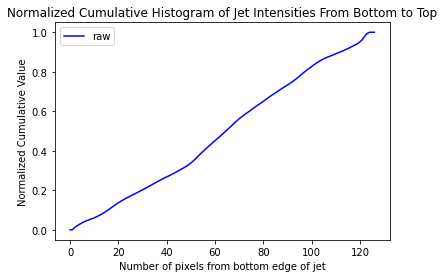


Length of Jet in Pixels: 119 pixels
Jet Length in cm (y-direction): 2.389996e+22 cm
Jet Length in kpc (y-direction): 7.7454 kpc
____________________________________________________________________________________________________

File Number 2/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_0100_nu=30.0_los=0.00_1.00_0.00_2.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 2.0 Myr - 30 MHz
Time index: 2.0001e+00 Myr
Pixel size: 2.0054e+20 cm
FITS Image Dimensions: 367x367 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


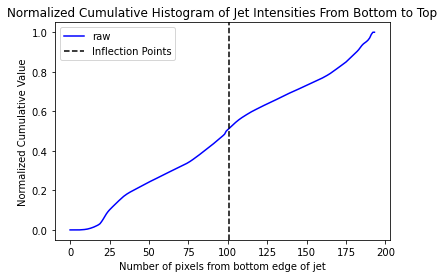


Length of Jet in Pixels: 174 pixels
Jet Length in cm (y-direction): 3.489396e+22 cm
Jet Length in kpc (y-direction): 11.3084 kpc
____________________________________________________________________________________________________

File Number 3/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_0200_nu=30.0_los=0.00_1.00_0.00_4.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 4.0 Myr - 30 MHz
Time index: 4.0001e+00 Myr
Pixel size: 2.0036e+20 cm
FITS Image Dimensions: 559x559 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


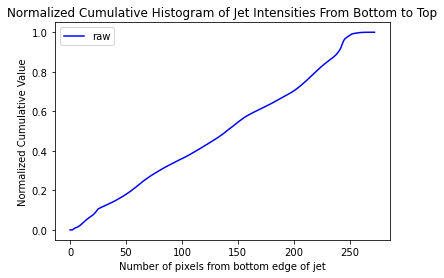


Length of Jet in Pixels: 240 pixels
Jet Length in cm (y-direction): 4.80864e+22 cm
Jet Length in kpc (y-direction): 15.5837 kpc
____________________________________________________________________________________________________

File Number 4/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_0400_nu=30.0_los=0.00_1.00_0.00_8.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 8.0 Myr - 30 MHz
Time index: 8.0000e+00 Myr
Pixel size: 2.0027e+20 cm
FITS Image Dimensions: 751x751 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


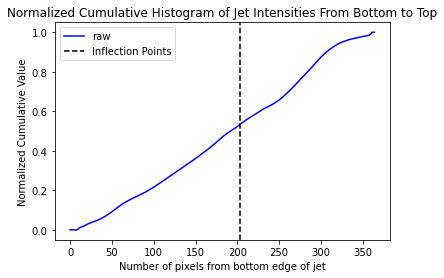


Length of Jet in Pixels: 336 pixels
Jet Length in cm (y-direction): 6.729072e+22 cm
Jet Length in kpc (y-direction): 21.8074 kpc
____________________________________________________________________________________________________

File Number 5/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_0800_nu=30.0_los=0.00_1.00_0.00_16.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 16.0 Myr - 30 MHz
Time index: 1.6000e+01 Myr
Pixel size: 2.0018e+20 cm
FITS Image Dimensions: 1135x1135 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


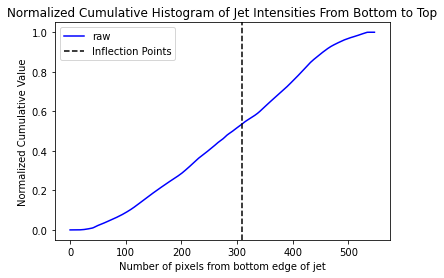


Length of Jet in Pixels: 465 pixels
Jet Length in cm (y-direction): 9.30837e+22 cm
Jet Length in kpc (y-direction): 30.1664 kpc
____________________________________________________________________________________________________

File Number 6/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_1600_nu=30.0_los=0.00_1.00_0.00_32.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 32.0 Myr - 30 MHz
Time index: 3.2000e+01 Myr
Pixel size: 2.0013e+20 cm
FITS Image Dimensions: 1519x1519 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


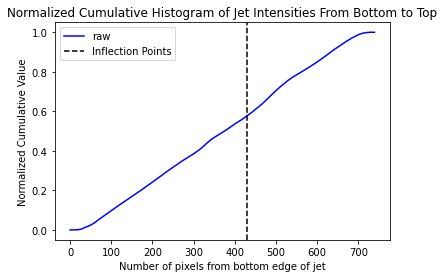


Length of Jet in Pixels: 647 pixels
Jet Length in cm (y-direction): 1.2948411e+23 cm
Jet Length in kpc (y-direction): 41.9629 kpc
____________________________________________________________________________________________________

File Number 7/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_3200_nu=30.0_los=0.00_1.00_0.00_64.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 64.0 Myr - 30 MHz
Time index: 6.4002e+01 Myr
Pixel size: 2.0010e+20 cm
FITS Image Dimensions: 2095x2095 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


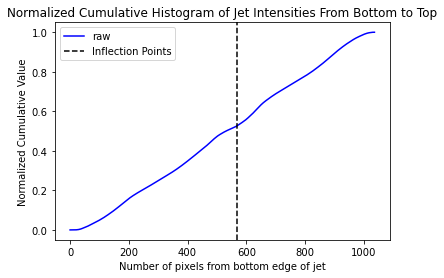


Length of Jet in Pixels: 925 pixels
Jet Length in cm (y-direction): 1.850925e+23 cm
Jet Length in kpc (y-direction): 59.9844 kpc
____________________________________________________________________________________________________

File Number 8/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_3280_nu=30.0_los=0.00_1.00_0.00_80.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 80.0 Myr - 30 MHz
Time index: 8.0002e+01 Myr
Pixel size: 2.0000e+20 cm
FITS Image Dimensions: 2320x2320 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[]


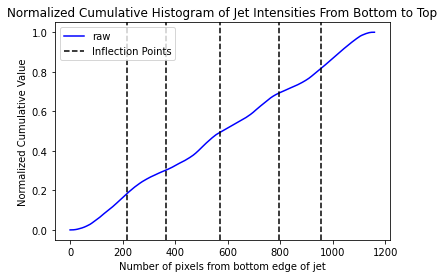


Length of Jet in Pixels: 1041 pixels
Jet Length in cm (y-direction): 2.082e+23 cm
Jet Length in kpc (y-direction): 67.473 kpc
____________________________________________________________________________________________________

File Number 9/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_3440_nu=30.0_los=0.00_1.00_0.00_112.0Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 112.0 Myr - 30 MHz
Time index: 1.1200e+02 Myr
Pixel size: 2.0000e+20 cm
FITS Image Dimensions: 3024x3024 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[673, 903]


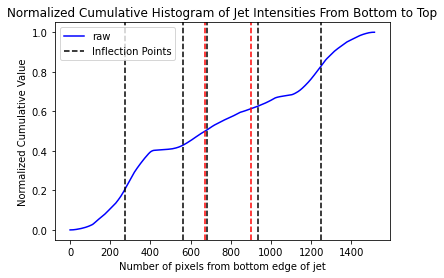


Length of Jet in Pixels: 1339 pixels
Jet Length in cm (y-direction): 2.678e+23 cm
Jet Length in kpc (y-direction): 86.7881 kpc
[673, 903]


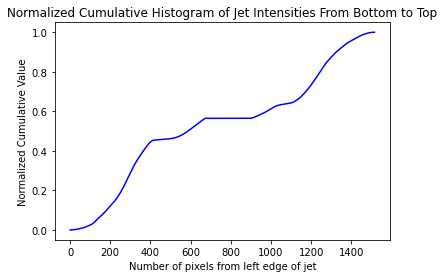


Length of Jet in Pixels: 1350 pixels
Jet Length in cm (y-direction): 2.7e+23 cm
Jet Length in kpc (y-direction): 87.501 kpc
____________________________________________________________________________________________________

File Number 10/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_3518_nu=30.0_los=0.00_1.00_0.00_127.6Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 127.6 Myr - 30 MHz
Time index: 1.2760e+02 Myr
Pixel size: 2.0000e+20 cm
FITS Image Dimensions: 3408x3408 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[683, 1092]


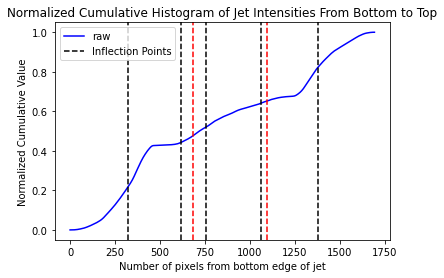


Length of Jet in Pixels: 1493 pixels
Jet Length in cm (y-direction): 2.986e+23 cm
Jet Length in kpc (y-direction): 96.7697 kpc
[683, 1092]


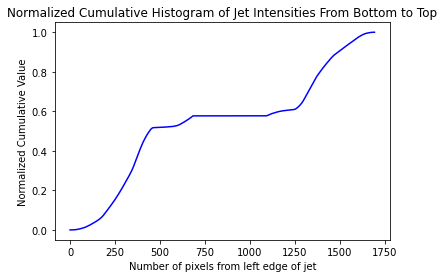


Length of Jet in Pixels: 1511 pixels
Jet Length in cm (y-direction): 3.022e+23 cm
Jet Length in kpc (y-direction): 97.9364 kpc
____________________________________________________________________________________________________

File Number 11/11

File Name: Jet Simulation Data/Group_L430_rc30_beta07/fits/nu=30.0MHz/Group_L430_rc30_beta07_4068_nu=30.0_los=0.00_1.00_0.00_237.6Myr.fits.gz
Simulation Title: Simulation Group_L430_rc30_beta07 - 237.6 Myr - 30 MHz
Time index: 2.3761e+02 Myr
Pixel size: 2.0004e+20 cm
FITS Image Dimensions: 5199x5199 pixels 


JET LENGTH DATA:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[708, 1936]


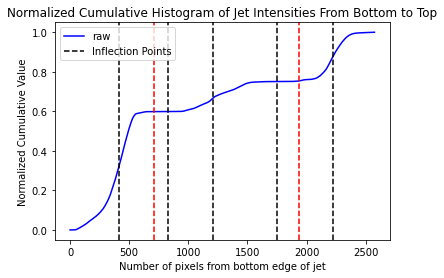


Length of Jet in Pixels: 2241 pixels
Jet Length in cm (y-direction): 4.4828964e+23 cm
Jet Length in kpc (y-direction): 145.2808 kpc
[708]
____________________________________________________________________________________________________



In [4]:
#Main Calling Block of Code

print("\nJET LENGTH AND WIDTH DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

path = '**/Group_L430_rc30_*nu=30.0*0.00_1.00_0.00*Myr.fits*'

# Determines if there are any files in device
total_files = len(glob.glob(path, recursive=True))

if total_files > 0:
    file_count = 0
    for file in sorted(glob.glob(path, recursive=True)):

        file_count += 1

        try:
            print("File Number {}/{}\n".format(file_count, total_files))
            print("File Name: {}".format(file))
            fits_image_hdul = fits.open(file)

            #Displays FITS Image title, time index, and pixel size
            sim_title = fits_image_hdul[0].header['OBJECT']
            sim_time = fits_image_hdul[0].header['TIME']
            pixel = fits_image_hdul[0].header['CDELT1']
            print("Simulation Title: {}".format(sim_title))
            print("Time index: {}".format(sim_time))
            print("Pixel size: {}".format(pixel))
            pixel_size = float(pixel[:-3])

            #Difines Data From FITS image and records image dimensions
            data =  fits_image_hdul[0].data
            length = len(data[0])
            width = len(data)
            print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))

            #Calls jet_length function
            print("\nJET LENGTH DATA:")
            print("{}\n".format("~"*50))
            jet_length(data, pixel_size)

            #Calls jet_width function
            #print("\nJET WIDTH DATA:")
            #print("{}\n".format("~"*50))
            #jet_width(data, width, pixel_size)

            print("{}\n".format("_"*100))

        except OSError:
            print("Error with file: {}".format(file))
            print("Empty or corrupt FITS file")
            
else:
    print("ERROR: Could not find any necessary files on your device")
    print("Program intakes files of the name: {}".format(path))